# Proyek Klasifikasi Gambar: [augmented-apple-disease-detection-dataset]
- **Nama:** [Aditiya Saputra]
- **Email:** [AditiyaS1811@gmail.com]
- **ID Dicoding:** [aditiya18]

Source Dataset : https://www.kaggle.com/datasets/rm1000/augmented-apple-disease-detection-dataset

## Import Semua Packages/Library yang Digunakan

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
from PIL import Image
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

## Data Preparation

### Data Loading

In [2]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d rm1000/augmented-apple-disease-detection-dataset

Dataset URL: https://www.kaggle.com/datasets/rm1000/augmented-apple-disease-detection-dataset
License(s): CC0-1.0


**Read Dataset**

In [4]:
with zipfile.ZipFile('/content/augmented-apple-disease-detection-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('augmented-apple-disease-detection-dataset')

def print_images_resolution(directory):
    """
    Mencetak jumlah gambar di setiap subdirektori dan resolusi unik setiap gambar.
    Args:
        directory (str): Path folder dataset.
    """
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if not os.path.isdir(subdir_path):
            continue  # Skip jika bukan direktori

        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images} images")
        total_images += num_images

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            try:
                with Image.open(img_path) as img:
                    unique_sizes.add(img.size)
            except Exception as e:
                print(f"Error opening image {img_file}: {e}")

        print("Unique resolutions:")
        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")
        unique_sizes.clear()  # Reset untuk subdir berikutnya

    print(f"\nTotal images: {total_images}")

dataset_folder = "/content/augmented-apple-disease-detection-dataset/train_augmented"
print_images_resolution(dataset_folder)

Black Rot: 3000 images
Unique resolutions:
- (224, 224)
- (256, 256)
---------------
Cedar Apple Rust: 3000 images
Unique resolutions:
- (224, 224)
- (256, 256)
---------------
Healthy: 3000 images
Unique resolutions:
- (224, 224)
- (256, 256)
---------------
Apple Scab: 3000 images
Unique resolutions:
- (224, 224)
- (256, 256)
---------------

Total images: 12000


### Data Preprocessing

**Menyamakan Resolusi Setiap Gambar**

In [5]:
#Fungsi Resize semua gambar jadi 224x224
def resize_images_to_224(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        output_class_path = os.path.join(output_dir, class_name)
        os.makedirs(output_class_path, exist_ok=True)

        for img_name in os.listdir(class_path):
            input_img_path = os.path.join(class_path, img_name)
            output_img_path = os.path.join(output_class_path, img_name)

            try:
                with Image.open(input_img_path) as img:
                    img = img.resize((224, 224))
                    img.save(output_img_path)
            except Exception as e:
                print(f"Error resizing image {input_img_path}: {e}")

# Resize dataset train_augmented
original_dataset = '/content/augmented-apple-disease-detection-dataset/train_augmented'
resized_dataset = '/content/resized-apple-dataset-224'
resize_images_to_224(original_dataset, resized_dataset)

# 3. Fungsi cek jumlah gambar dan resolusi
def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if not os.path.isdir(subdir_path):
            continue

        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images} images")
        total_images += num_images

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            try:
                with Image.open(img_path) as img:
                    unique_sizes.add(img.size)
            except Exception as e:
                print(f"Error opening image {img_file}: {e}")

        print("Unique resolutions:")
        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")
        unique_sizes.clear()

    print(f"\nTotal images: {total_images}")

# Jalankan pengecekan resolusi
print_images_resolution(resized_dataset)

Black Rot: 3000 images
Unique resolutions:
- (224, 224)
---------------
Cedar Apple Rust: 3000 images
Unique resolutions:
- (224, 224)
---------------
Healthy: 3000 images
Unique resolutions:
- (224, 224)
---------------
Apple Scab: 3000 images
Unique resolutions:
- (224, 224)
---------------

Total images: 12000


#### Split Dataset

In [6]:
# Direktori dataset yang sudah di samakan resolusinya
dataset_dir = "/content/resized-apple-dataset-224"

# List tiap class
classes = ["Apple Scab", "Black Rot", "Cedar Apple Rust", "Healthy"]

# Ratio train, validation, dan test sets
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Loop tiap class
for class_name in classes:
    # Path to the current class directory
    class_dir = os.path.join(dataset_dir, class_name)

    # List all files in the class directory
    files = os.listdir(class_dir)

    # Split files into train, val, test using sklearn train_test_split twice
    # First split: train (80%), remaining (20%)
    train_files, remaining_files = train_test_split(files, train_size=train_ratio, random_state=42)

    # Second split: val (10%), test (10%)
    val_files, test_files = train_test_split(remaining_files, train_size=0.5, random_state=42)

    # Membuat direktori baru train, validation, dan test sets
    for folder_name, file_list in [("train", train_files), ("val", val_files), ("test", test_files)]:
        folder_path = os.path.join(dataset_dir, folder_name, class_name)
        os.makedirs(folder_path, exist_ok=True)

        # Pindah file ke tempat yang sesuai dengan class
        for file in file_list:
            src = os.path.join(class_dir, file)
            dst = os.path.join(folder_path, file)
            shutil.move(src, dst)

print("Dataset berhasil dibagi menjadi 80% train,10% test, dan 10% validation.")


Dataset berhasil dibagi menjadi 80% train,10% test, dan 10% validation.


**Augmentasi**

In [7]:
# Direktori dataset
dataset_dir = "/content/resized-apple-dataset-224"

# Dimensi sebuah gambar
img_width, img_height = 256, 256

# ukuran Batch image
batch_size = 32

# Data augmentation dan normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0,1]
 )
val_datagen = ImageDataGenerator(rescale=1./255)  #  normalization for validation set
test_datagen = ImageDataGenerator(rescale=1./255)  # normalization for test set

# Data generators
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(dataset_dir, 'train'),
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    directory=os.path.join(dataset_dir, 'val'),
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    directory=os.path.join(dataset_dir, 'test'),
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 9600 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.


## Modelling

In [8]:
num_classes = len(["Apple Scab", "Black Rot", "Cedar Apple Rust", "Healthy"])

# Membuat model Sequential
model = Sequential()

# Layer Convolutional pertama dengan MaxPooling
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer Convolutional kedua dengan MaxPooling
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer Convolutional ketiga dengan MaxPooling
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten layer untuk mengubah data ke dimensi 1D
model.add(Flatten())

# Fully connected layer (Dense) dengan dropout
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer dengan softmax
model.add(Dense(num_classes, activation='softmax'))

# Kompilasi model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Menampilkan arsitektur model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,492 (56.61 MB)

 Trainable params: 14,839,492 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
class CustomStopCallback(Callback):
    def __init__(self, threshold=0.98):
        super(CustomStopCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        train_acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')
        if train_acc > self.threshold and val_acc > self.threshold:
            print(f"\nAkurasi sudah mencapai {self.threshold * 100:.2f}%! Menghentikan pelatihan.")
            self.model.stop_training = True

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    min_delta=0.01,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

custom_stop_callback = CustomStopCallback(threshold=0.97)

# Latih Model dengan Callbacks
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[early_stopping, model_checkpoint, custom_stop_callback]
)

Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9789 - loss: 0.0640
Epoch 1: val_accuracy improved from -inf to 0.96917, saving model to best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 31s 104ms/step - accuracy: 0.9789 - loss: 0.0640 - val_accuracy: 0.9692 - val_loss: 0.0973
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9845 - loss: 0.0419
Epoch 2: val_accuracy improved from 0.96917 to 0.97417, saving model to best_model.keras

Akurasi sudah mencapai 97.00%! Menghentikan pelatihan.
300/300 ━━━━━━━━━━━━━━━━━━━━ 39s 130ms/step - accuracy: 0.9845 - loss: 0.0419 - val_accuracy: 0.9742 - val_loss: 0.0874


## Evaluasi dan Visualisasi

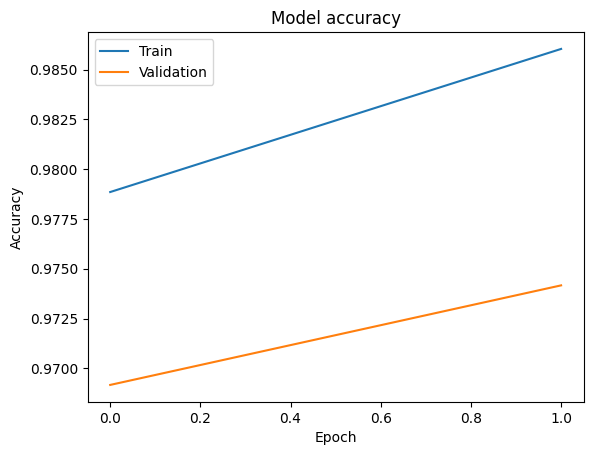

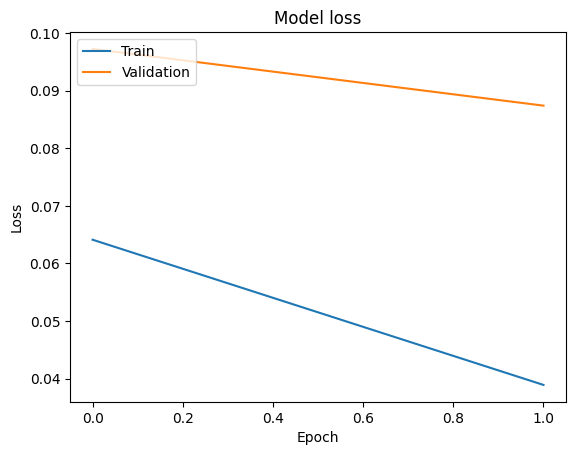

In [13]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Evaluasi Mode Confusion Matrix, Precission, recall, dan F1-Score**

38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step


<Figure size 800x800 with 0 Axes>

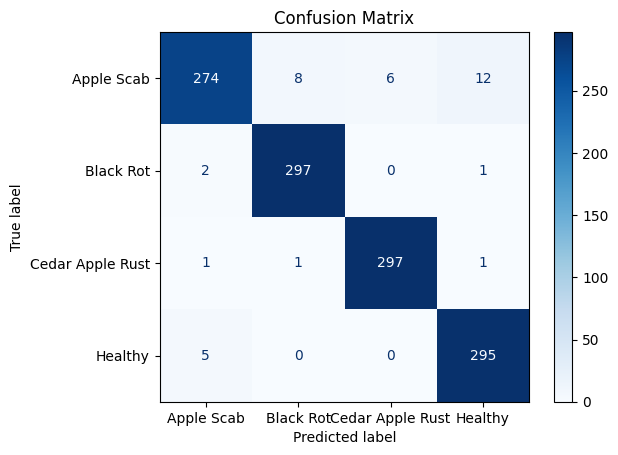

                  precision    recall  f1-score   support

      Apple Scab       0.97      0.91      0.94       300
       Black Rot       0.97      0.99      0.98       300
Cedar Apple Rust       0.98      0.99      0.99       300
         Healthy       0.95      0.98      0.97       300

        accuracy                           0.97      1200
       macro avg       0.97      0.97      0.97      1200
    weighted avg       0.97      0.97      0.97      1200



In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Ambil prediksi kelas dari model pada dataset uji
y_pred = np.argmax(model.predict(test_generator), axis=1)

# Ambil label sebenarnya dari dataset uji
y_true = test_generator.classes

# Hitung confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Definisikan kelas label
classes = ["Apple Scab", "Black Rot", "Cedar Apple Rust", "Healthy"]

# Tampilkan confusion matrix
plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Hitung dan tampilkan classification report (precision, recall, F1-score)
report = classification_report(y_true, y_pred, target_names=classes)
print(report)


## Konversi Model

In [26]:
!pip install tensorflowjs
import tensorflowjs as tfjs

# Direktori untuk menyimpan model
save_dir = './submission'
subject = 'apple-disease'
os.makedirs(save_dir, exist_ok=True)

# 1. Simpan sebagai SavedModel
saved_model_dir = os.path.join(save_dir, 'saved_model')
tf.saved_model.save(model, saved_model_dir)
print(f"✅ Model disimpan sebagai SavedModel di: {saved_model_dir}")

# 2. Simpan sebagai TFLite (tanpa optimasi)
tflite_dir = os.path.join(save_dir, 'tflite')
os.makedirs(tflite_dir, exist_ok=True)
tflite_model_path = os.path.join(tflite_dir, 'model.tflite')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)
print(f"✅ Model TFLite (tanpa optimasi) disimpan di: {tflite_model_path}")

# 2b. Simpan label untuk TFLite
labels = ["Apple Scab", "Black Rot", "Cedar Apple Rust", "Healthy"]
with open(os.path.join(tflite_dir, 'label.txt'), 'w') as f:
    for label in labels:
        f.write(label + '\n')
print("✅ label.txt disimpan untuk TFLite")

# 3. Simpan sebagai TFJS
tfjs_model_dir = os.path.join(save_dir, 'tfjs_model')
os.makedirs(tfjs_model_dir, exist_ok=True)
tfjs.converters.save_keras_model(model, tfjs_model_dir)
print(f"✅ Model disimpan dalam format TensorFlow.js di: {tfjs_model_dir}")

# 4. Zip seluruh folder submission
shutil.make_archive(save_dir, 'zip', save_dir)
print(f"📦 Folder 'submission/' berhasil di-zip menjadi '{save_dir}.zip'")

✅ Model disimpan sebagai SavedModel di: ./submission/saved_model
Saved artifact at '/tmp/tmpqwt38oen'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  140086757897424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140086768941200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140086768940624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140086749512336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140086749515216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140086749514832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140086749514640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140086749516176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140086749514256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140086749517904: Te

✅ Model TFLite (tanpa optimasi) disimpan di: ./submission/tflite/model.tflite
✅ label.txt disimpan untuk TFLite
failed to lookup keras version from the file,
    this is likely a weight only file
✅ Model disimpan dalam format TensorFlow.js di: ./submission/tfjs_model
📦 Folder 'submission/' berhasil di-zip menjadi './submission.zip'


## Inference (Optional)

Load TFLite

✅ Prediksi kelas: Apple Scab
Prediksi probabilitas: 1.0000


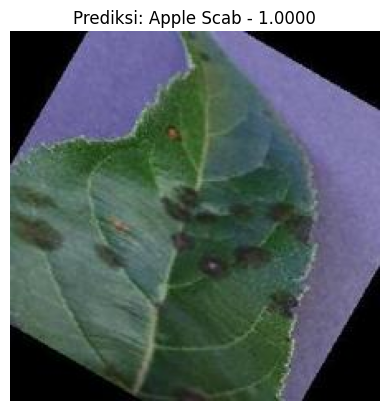


Probabilitas untuk setiap kelas:
Apple Scab: 1.0000
Black Rot: 0.0000
Cedar Apple Rust: 0.0000
Healthy: 0.0000


In [27]:
# Fungsi untuk memuat dan memproses gambar
def preprocess_image(image_path, target_size=(256, 256)):  # Ubah target_size menjadi (256, 256)
    img = Image.open(image_path)
    img = img.convert('RGB')  # Pastikan gambar dalam format RGB
    img = img.resize(target_size)  # Resize ke ukuran yang diinginkan
    img_array = np.array(img)  # Ubah gambar menjadi array
    img_array = img_array / 255.0  # Normalisasi gambar
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch
    return img_array.astype(np.float32)  # Mengubah tipe data menjadi float32

# Fungsi untuk melakukan inference menggunakan model TFLite
def predict_image(image_path, tflite_model_path='./submission/tflite/model.tflite', label_file='./submission/tflite/label.txt'):
    # Load model TFLite
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    # Load label file
    with open(label_file, 'r') as f:
        labels = [line.strip() for line in f.readlines()]

    # Preprocess gambar
    img = preprocess_image(image_path)

    # Mendapatkan input dan output tensor dari model TFLite
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Set input tensor
    input_index = input_details[0]['index']
    interpreter.set_tensor(input_index, img)

    # Jalankan inference
    interpreter.invoke()

    # Ambil hasil dari output tensor
    output_index = output_details[0]['index']
    predictions = interpreter.get_tensor(output_index)

    # Ambil kelas dengan probabilitas tertinggi
    predicted_class = np.argmax(predictions)

    # Tampilkan hasil prediksi
    print(f"✅ Prediksi kelas: {labels[predicted_class]}")
    print(f"Prediksi probabilitas: {predictions[0][predicted_class]:.4f}")

    # Menampilkan gambar
    img_pil = Image.open(image_path)
    plt.imshow(img_pil)
    plt.title(f"Prediksi: {labels[predicted_class]} - {predictions[0][predicted_class]:.4f}")
    plt.axis('off')
    plt.show()

    # Menampilkan probabilitas untuk setiap kelas
    print("\nProbabilitas untuk setiap kelas:")
    for i, label in enumerate(labels):
        print(f"{label}: {predictions[0][i]:.4f}")

    return labels[predicted_class], predictions[0][predicted_class], predictions[0]

# Contoh penggunaan
image_path = '/content/resized-apple-dataset-224/val/Apple Scab/01a66316-0e98-4d3b-a56f-d78752cd043f___FREC_Scab 3003_new30degFlipLR.JPG'  # Ganti dengan path gambar yang ingin diprediksi
predicted_label, prediction_probability, all_predictions = predict_image(image_path)